In [1]:
import numpy as np
import pandas as pd
from utils import take_derivative, import_data, unit_scale, remove_outliers, cut_ends
from models.data_validation import ReportErrors
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

## Read in metadata table and flag time series with obvious data faults

In [2]:
metadata = pd.read_csv("data/metadata.csv")

In [3]:
metadata.head()

,Node ID,Site ID,Project,Site type,Mount Type,Offset (mm),Dam nearby,Clean,Low Var Obst,High Var Obst,Indeterminate,Outliers,Unnamed: 12
0,001A,ARB025,ARB,River,Bridge - S,4905.50,0,0,1,0,0,0,1
1,001A,MDOT11328,MDO,River,Bridge - D,9448.80,0,0,1,0,0,0,1
2,001A,PTK014,PTK,Stream,Post,1841.50,0,0,1,0,1,0,1
3,003A,ARB017,ARB,Stream,Post,1517.65,0,0,1,0,1,0,1
4,004A,MDOT335,MDO,Lake,Bridge - S,2476.50,0,1,0,0,0,0,1


In [4]:
print("clean sites: ", len(metadata[metadata['Clean']==1]))
print("Low var obst: ", len(metadata[metadata['Low Var Obst']==1]))
print("High var obst: ", len(metadata[metadata['High Var Obst']==1]))
print("Total sites: ", len(metadata))

clean sites:  80
Low var obst:  35
High var obst:  44
Total sites:  159


In [5]:
flags = []
for i in range(len(metadata)):
    df = import_data(index = i)
    offset = metadata.iloc[i]['Offset (mm)']
    df, neg_flag, sat_flag = ReportErrors.detect_out_of_range(df, offset)
    df, und_flag = ReportErrors.detect_underliers(df)
    flags.append({'neg_flag':neg_flag, "sat_flag":sat_flag, "und_flag":und_flag})
    
metadata_mod = metadata.join(pd.DataFrame(flags), how="outer")
print("Negative flags: ", len(metadata_mod[metadata_mod["neg_flag"]==1]))
print("Saturation flags: ", len(metadata_mod[metadata_mod["sat_flag"]==1]))
print("Underlier flags: ", len(metadata_mod[metadata_mod["und_flag"]==1]))
tmp = metadata_mod[metadata_mod["neg_flag"]==0]
tmp = tmp[tmp["sat_flag"]==0]
tmp = tmp[tmp["und_flag"]==0]
print("Test Set: ",len(tmp))
test_set = tmp

clean = test_set[test_set['Clean']==1]
obst = test_set[test_set['Clean']==0]

Negative flags:  18
Saturation flags:  20
Underlier flags:  9
Test Set:  121


## Classification on $\hat{X}=x(t)$ Dataset

We start by looking at binary classification on the 1 dimensional time series data. The derivative is not passed in as a feature. 

In [6]:
def format_data1D(nbins=10):
    y = []
    for i in range(len(test_set)):
        if test_set.iloc[i]['Clean'] == 1:
            y.append(0)
        else:
            y.append(1)
    
    data = []
    for i, col in test_set.iterrows():
        df = import_data(index = i)
        df = cut_ends(df)
        df, df_down, df_up = take_derivative(df)
        if len(df_down) == 0:
            X = np.zeros((nbins,nbins))
        else:
            X = unit_scale(df_down)
        h, x_e = np.histogram(X[:,0],nbins)
        h = np.reshape(h, (-1,1))
        mm = make_pipeline(StandardScaler(), MinMaxScaler())

        h = mm.fit_transform(h)

        data.append(np.ndarray.flatten(h))
        
    return np.array(data), np.array(y)

In [7]:
data, y = format_data1D()

In [136]:
### Support Vector Machine
params = [{'kernel':['linear', 'rbf', 'poly'], 'C':[0.1, 1, 10, 100]}]
clf_pipe = SVC()
gs_clf = GridSearchCV(clf_pipe, param_grid=params, scoring='accuracy', cv=5)
gs_clf.fit(data, y)
print("params: ", gs_clf.best_params_)

params:  {'C': 100, 'kernel': 'linear'}


In [137]:
clf = SVC(kernel='linear', C=100)
y_pred = cross_val_predict(clf, data, y, cv=5)
print("accuracy score: ", len(np.where(y_pred - y ==0)[0])/len(y))

accuracy score:  0.6694214876033058


In [138]:
### KNN
params = [{'n_neighbors':[3,4,5,6,7,8]}]
knn_pipe = KNeighborsClassifier() 
gs_knn = GridSearchCV(knn_pipe, param_grid=params, scoring='accuracy', cv=5)
gs_knn.fit(data, y)
print("params: ", gs_knn.best_params_)

params:  {'n_neighbors': 7}


In [139]:
knn = KNeighborsClassifier(n_neighbors=7) 
y_pred = cross_val_predict(knn, data, y, cv=5)
print("accuracy score: ", len(np.where(y_pred - y ==0)[0])/len(y))

accuracy score:  0.6528925619834711


In [8]:
### AdaBoost
params = [{'n_estimators':[10,25,50,100,250], 'random_state': [0,1,2,3,4,5,6,7,8]}]
ada_pipe = AdaBoostClassifier() 
gs_ada = GridSearchCV(ada_pipe, param_grid=params, scoring='accuracy', cv=5)
gs_ada.fit(data, y)
print("params: ", gs_ada.best_params_)

params:  {'n_estimators': 10, 'random_state': 0}


In [9]:
ada = AdaBoostClassifier(n_estimators=10, random_state=0)
y_pred = cross_val_predict(ada, data, y, cv=5)
print("accuracy score: ", len(np.where(y_pred - y ==0)[0])/len(y))

accuracy score:  0.6611570247933884


In [10]:
### Gaussian Process
params = [{'kernel': [RBF(0.1), RBF(1), RBF(10), 
                      RationalQuadratic(alpha=1), RationalQuadratic(alpha=10), RationalQuadratic(alpha=100), 
                     Matern(length_scale=0.1, nu=1.5), Matern(length_scale=1, nu=1.5), Matern(length_scale=10, nu=1.5),
                     Matern(length_scale=0.1, nu=2.5), Matern(length_scale=1, nu=2.5), Matern(length_scale=10, nu=2.5)], 
          'random_state': [0,1,2,3,4,5,6,7,8]}]
gp_pipe = GaussianProcessClassifier() 
gs_gp = GridSearchCV(gp_pipe, param_grid=params, scoring='accuracy', cv=5)
gs_gp.fit(data, y)
print("params: ", gs_gp.best_params_)

params:  {'kernel': Matern(length_scale=0.1, nu=1.5), 'random_state': 0}


In [11]:
gp = GaussianProcessClassifier(Matern(length_scale=0.1, nu=1.5), random_state=0)
y_pred = cross_val_predict(gp, data, y, cv=5)
print("accuracy score: ", len(np.where(y_pred - y ==0)[0])/len(y))

accuracy score:  0.6363636363636364


In [113]:
### MLP NN
params = [{'alpha': [0.001, 0.01, 0.1, 1], 'random_state': [0,1,2,3,4,5,6,7,8]}]
mlp_pipe = MLPClassifier()
gs_mlp = GridSearchCV(mlp_pipe, param_grid=params, scoring='accuracy', cv=5)
gs_mlp.fit(data, y)
print("params: ", gs_mlp.best_params_)

params:  {'alpha': 1, 'random_state': 0}


In [112]:
mlp = MLPClassifier(alpha=1, random_state=0)
y_pred = cross_val_predict(mlp, data, y, cv=5)
print("accuracy score: ", len(np.where(y_pred - y ==0)[0])/len(y))

accuracy score:  0.6446280991735537


## Classification on $\hat{X}=\left[x(t), \frac{dx}{dt}\right]$ Dataset

Now we look at binary classification on the phase portrait dataset. The best classifier is MLP NN with alpha=0.001 with a classification accuracy of 78.5%. Even using cross validation to generate the final model precictons, some classifiers are sensitive to random state. This sensitivity is typically on the order of +/- 3%. 

In [17]:
def format_data(nbins=10):
    
    # pull obstruction labels from metadata table
    y = []
    for i in range(len(test_set)):
        if test_set.iloc[i]['Clean'] == 1:
            y.append(0) # 0 not obstructed
        else:
            y.append(1) # 1 if obstructed
    
    # format features X
    data = []
    for i, col in test_set.iterrows():
        df = import_data(index = i)
        df = cut_ends(df) # clip data to only include 1-99th value percentile data
        df, df_down, df_up = take_derivative(df)
        if len(df_down) == 0:
            X = np.zeros((nbins,nbins))
        else:
            X = unit_scale(df_down) # unit scale phase portrait features
        h, x_e, y_e = np.histogram2d(X[:,0], X[:,1],nbins) # bin phase portrait
        mm = make_pipeline(StandardScaler(), MinMaxScaler()) 
        h = mm.fit_transform(h) # standardize and unit scale histogram

        data.append(np.ndarray.flatten(h))
        
    return np.array(data), np.array(y)

In [18]:
data, y = format_data()

In [117]:
### Support Vector Machine
params = [{'kernel':['linear', 'rbf', 'poly'], 'C':[0.1, 1, 10, 100]}]
clf_pipe = SVC()
gs_clf = GridSearchCV(clf_pipe, param_grid=params, scoring='accuracy', cv=5)
gs_clf.fit(data, y)
print("params: ", gs_clf.best_params_)

params:  {'C': 1, 'kernel': 'rbf'}


In [118]:
clf = SVC(kernel='rbf', C=1)
y_pred = cross_val_predict(clf, data, y, cv=5)
print("accuracy score: ", len(np.where(y_pred - y ==0)[0])/len(y))

accuracy score:  0.7603305785123967


In [119]:
### KNN
params = [{'n_neighbors':[3,4,5,6,7,8]}]
knn_pipe = KNeighborsClassifier() 
gs_knn = GridSearchCV(knn_pipe, param_grid=params, scoring='accuracy', cv=5)
gs_knn.fit(data, y)
print("params: ", gs_knn.best_params_)

params:  {'n_neighbors': 7}


In [120]:
knn = KNeighborsClassifier(n_neighbors=7) 
y_pred = cross_val_predict(knn, data, y, cv=5)
print("accuracy score: ", len(np.where(y_pred - y ==0)[0])/len(y))

accuracy score:  0.768595041322314


In [19]:
### AdaBoost
params = [{'n_estimators':[10,25,50,100,250], 'random_state': [0,1,2,3,4,5,6,7,8]}]
ada_pipe = AdaBoostClassifier() 
gs_ada = GridSearchCV(ada_pipe, param_grid=params, scoring='accuracy', cv=5)
gs_ada.fit(data, y)
print("params: ", gs_ada.best_params_)

params:  {'n_estimators': 10, 'random_state': 0}


In [20]:
ada = AdaBoostClassifier(n_estimators=10, random_state=0)
y_pred = cross_val_predict(ada, data, y, cv=5)
print("accuracy score: ", len(np.where(y_pred - y ==0)[0])/len(y))

accuracy score:  0.7520661157024794


In [21]:
### Gaussian Process
params = [{'kernel': [RBF(0.1), RBF(1), RBF(10), 
                      RationalQuadratic(alpha=1), RationalQuadratic(alpha=10), RationalQuadratic(alpha=100), 
                     Matern(length_scale=0.1, nu=1.5), Matern(length_scale=1, nu=1.5), Matern(length_scale=10, nu=1.5),
                     Matern(length_scale=0.1, nu=2.5), Matern(length_scale=1, nu=2.5), Matern(length_scale=10, nu=2.5)], 
          'random_state': [0,1,2,3,4,5,6,7,8]}]
gp_pipe = GaussianProcessClassifier() 
gs_gp = GridSearchCV(gp_pipe, param_grid=params, scoring='accuracy', cv=5)
gs_gp.fit(data, y)
print("params: ", gs_gp.best_params_)

params:  {'kernel': RBF(length_scale=1), 'random_state': 0}


In [22]:
gp = GaussianProcessClassifier(RBF(1), random_state=0)
y_pred = cross_val_predict(gp, data, y, cv=5)
print("accuracy score: ", len(np.where(y_pred - y ==0)[0])/len(y))

accuracy score:  0.7603305785123967


In [126]:
### MLP NN
params = [{'alpha': [0.001, 0.01, 0.1, 1], 'random_state': [0,1,2,3,4,5,6,7,8]}]
mlp_pipe = MLPClassifier()
gs_mlp = GridSearchCV(mlp_pipe, param_grid=params, scoring='accuracy', cv=5)
gs_mlp.fit(data, y)
print("params: ", gs_mlp.best_params_)

params:  {'alpha': 0.001, 'random_state': 4}


In [127]:
mlp = MLPClassifier(alpha=0.001, random_state=4)
y_pred = cross_val_predict(mlp, data, y, cv=5)
print("accuracy score: ", len(np.where(y_pred - y ==0)[0])/len(y))

accuracy score:  0.7851239669421488


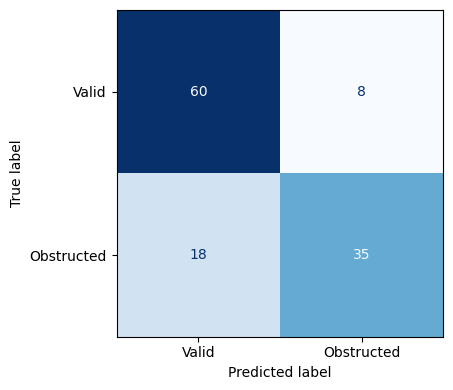

In [130]:
fig, ax = plt.subplots(figsize=(6,4))
ConfusionMatrixDisplay.from_predictions(y,y_pred, cmap='Blues', ax=ax, 
                                        colorbar=False, display_labels=["Valid", "Obstructed"])
plt.tight_layout()